In [1]:
conda env list


# conda environments:
#
base                     /Users/achartra/Applications/miniforge3
PINNICLE                 /Users/achartra/Applications/miniforge3/envs/PINNICLE
PINNICLEplus          *  /Users/achartra/Applications/miniforge3/envs/PINNICLEplus
allison                  /Users/achartra/Applications/miniforge3/envs/allison
ml4pde                   /Users/achartra/Applications/miniforge3/envs/ml4pde


Note: you may need to restart the kernel to use updated packages.


**1. Set up the modules**<br />

In [1]:
# Testing PINNICLE
# Infer basal friction coefficients using SSA

import pinnicle as pinn
import numpy as np
import deepxde as dde
import matplotlib.pyplot as plt
from datetime import datetime

# Set up some configurations
dde.config.set_default_float('float64')
dde.config.disable_xla_jit()
dde.config.set_random_seed(1234)


Using backend: tensorflow
Other supported backends: tensorflow.compat.v1, pytorch, jax, paddle.
paddle supports more examples now and is recommended.
Disable just-in-time compilation with XLA.


Set the default float type to float64


**2. Set up the experiment for either SSA or MOLHO**<br />
Only use one of the two following cells

In [ ]:
# Set up experiment - SSA

# Load the correct data
issm_filename = "Ryder_issm2024-Dec-19_3"
datestr = datetime.now().strftime("%y-%b-%d")

issm_pinn_path = issm_filename + "_pinn" + datestr + "_L3"

# General parameters for training
# Setting up dictionaries
# order doesn't matter, but keys DO matter
hp = {}  # hp = 'hyperparameters'

# Define domain of computation
hp["shapefile"] = "./Ryder_32_09.exp"
# Define hyperparameters
hp["epochs"] = int(2e3)
hp["learning_rate"] = 0.001
hp["loss_function"] = "MSE"

yts = pinn.physics.Constants().yts
data_size = 100
data_size_ft = 1000
wt_uv = (1.0e-2*yts)**2.0
wt_uvb = (1.0e-1*yts)**2.0
wt_s = 5.0e-6
wt_H = 1.0e-5
wt_C = 1.0e-8
wt_B = 1.0e-16

# Load data ? 
# In data_size, each key:value pair defines a variable in the training. 
# if the key is not redefined in name_map, then it will be used as default 
# or set in the physics section above. The value associated with the key 
# gives the number of data points used for training.
# If the value is set to None, then only Dirichlet BC around the domain 
# boundary will be used for the corresponding key. If the variable is included
# in the training, but not given in data_size, then there will be no data for this variable in the training
flightTrack = {}
flightTrack["data_path"] = "Ryder_xyz_ds.mat"
flightTrack["data_size"] = {"H": data_size_ft}
flightTrack["X_map"] = {"x": "x", "y":"y"}
flightTrack["name_map"] = {"H": "thickness"}
flightTrack["source"] = "mat"
# hp["data"] = {"ft": flightTrack}

issm = {}
issm["data_path"] =  "Models/" + issm_filename + ".mat"
issm["data_size"] = {"u":data_size, "v":data_size, "s":data_size, "H":None, "C":None, "B":data_size}
hp["data"] = {"ISSM":issm}
hp["data"] = {"ISSM":issm, "ft": flightTrack}

# Define number of collocation points used to evaluate PDE residual
hp["num_collocation_points"] = data_size*2


# Add physics
yts = pinn.physics.Constants().yts

SSA = {}
SSA["scalar_variables"] = {"n":3}
                      # u      v      s    H      C     B
SSA["data_weights"] = [wt_uv, wt_uv, wt_s, wt_H, wt_C, wt_B]}
hp["equations"] = {"SSA_VB":SSA}
# If not using B,
# SSA["scalar_variables"] = {"n":3, "B":2.0e8}
                         # u      v      s    H      C  
# SSA["data_weights"] = [wt_uv, wt_uv, wt_s, wt_H, wt_C]}
# hp["equations"] = {"SSA":SSA}

# Set NN architecture
hp["activation"] = "tanh"
hp["initializer"] = "Glorot uniform"
hp["num_neurons"] = 20
hp["num_layers"] = 6
hp["input"] = ['y', 'x']

hp['fft'] = True
hp['sigma'] = 5
hp['num_fourier_feature'] = 30

hp["save_path"] = "./PINNs/" + issm_pinn_path
hp["is_save"] = True
hp["is_plot"] = True

# Add an additional loss function to balance the contributions between the fast flow and slow moving regions:
# vel_loss = {}
# vel_loss['name'] = "vel log"
# vel_loss['function'] = "VEL_LOG"
# vel_loss['weight'] = 1.0e-5
# hp["additional_loss"] = {"vel":vel_loss}

experiment = pinn.PINN(hp) # set up class PINN (in pinn.py in pinnicle package)
experiment.update_parameters(hp)
print(experiment.params) # make sure that settings are in correct spot (keys must be correct)

In [7]:
# Set up experiment - MOLHO

# Load the correct data
issm_filename = "Ryder_issm2024-Dec-19_3"
datestr = datetime.now().strftime("%y-%b-%d")

issm_pinn_path = issm_filename + "_pinn" + datestr + "_L3"

# General parameters for training
# Setting up dictionaries
# order doesn't matter, but keys DO matter
hp = {}  # hp = 'hyperparameters'

# Define domain of computation
hp["shapefile"] = "./Ryder_32_09.exp"
# Define hyperparameters
hp["epochs"] = int(2e3)
hp["learning_rate"] = 0.001
hp["loss_function"] = "MSE"

yts = pinn.physics.Constants().yts
data_size = 100
data_size_ft = 1000
wt_uv = (1.0e-2*yts)**2.0
wt_uvb = (1.0e-1*yts)**2.0
wt_s = 5.0e-6
wt_H = 1.0e-5
wt_C = 1.0e-8

# Load data ? 
# In data_size, each key:value pair defines a variable in the training. 
# if the key is not redefined in name_map, then it will be used as default 
# or set in the physics section above. The value associated with the key 
# gives the number of data points used for training.
# If the value is set to None, then only Dirichlet BC around the domain 
# boundary will be used for the corresponding key. If the variable is included
# in the training, but not given in data_size, then there will be no data for this variable in the training
flightTrack = {}
flightTrack["data_path"] = "Ryder_xyz_ds_vel_base.mat"
flightTrack["data_size"] = {"H": data_size_ft, "u_base":100, "v_base":100}
flightTrack["X_map"] = {"x": "x", "y":"y"}
flightTrack["name_map"] = {"H": "thickness","u_base":"u_base", "v_base":"v_base"}
flightTrack["source"] = "mat"

velbase = {}
velbase["data_path"] = "./Ryder_vel_base_ms.mat"
velbase["data_size"] = {"u_base":data_size, "v_base":data_size}
velbase["name_map"] = {"u_base":"md_u_base", "v_base":"md_v_base"}
velbase["X_map"] = {"x":"x", "y":"y"}
velbase["source"] = "mat"

issm = {}
issm["data_path"] = "./Models/" + issm_filename + ".mat"
issm["data_size"] = {"u":data_size, "v":data_size, "s":data_size, "H":None, "C":None} #, "B":10000}
hp["data"] = {"ISSM":issm, "ft":flightTrack, "velbase":velbase} # hp = 'hyperparameters'


# Define number of collocation points used to evaluate PDE residual
hp["num_collocation_points"] = 2000


# Add physics
yts = pinn.physics.Constants().yts

MOLHO = {}
MOLHO["scalar_variables"] = {"B":2e+08}
hp["equations"] = {"MOLHO":MOLHO}
                    #        u                 v                u_base               v_base            s        H      C
MOLHO["data_weights"] = [(1.0e-2*yts)**2.0, (1.0e-2*yts)**2.0, (1.0e-1*yts)**2.0, (1.0e-1*yts)**2.0, 5.0e-6, 5.0e-6, 5.0e-8]

MOLHO["output_lb"] =    [-1.0e4/yts,         -1.0e4/yts,         -1.0e2/yts,         -1.0e2/yts,     -1.0e3,  10.0, 0.01]
MOLHO["output_ub"] =    [1.0e4/yts,           1.0e4/yts,          1.0e2/yts,          1.0e2/yts,      4.0e3,  4.0e3, 1.0e4]
MOLHO["variable_lb"] =  [-1.0e4/yts,         -1.0e4/yts,         -1.0e2/yts,         -1.0e2/yts,     -1.0e3,  10.0, 0.01]
MOLHO["variable_ub"] =  [1.0e4/yts,           1.0e4/yts,          1.0e2/yts,          1.0e2/yts,      4.0e3,  4.0e3, 1.0e4]

# Set NN architecture
hp["activation"] = "tanh"
hp["initializer"] = "Glorot uniform"
hp["num_neurons"] = 20
hp["num_layers"] = 6
hp["input"] = ['y', 'x']

hp['fft'] = True
hp['sigma'] = 5
hp['num_fourier_feature'] = 30

hp["save_path"] = "./PINNs/" + issm_pinn_path
hp["is_save"] = True
hp["is_plot"] = True


experiment = pinn.PINN(hp) # set up class PINN (in pinn.py in pinnicle package)
experiment.update_parameters(hp)
print(experiment.params) # make sure that settings are in correct spot (keys must be correct)

ERROR:root:ERROR: MATLAB type not supported: qmustatistics, (uint32)
ERROR:root:ERROR: MATLAB type not supported: lovenumbers, (uint32)
ERROR:root:ERROR: MATLAB type not supported: rotational, (uint32)
ERROR:root:ERROR: MATLAB type not supported: solidearthsettings, (uint32)


add input transform with [ -128000. -1134000.] and [  22000. -984000.]
add output transform with [-3.1709792e-04 -3.1709792e-04 -3.1709792e-06 -3.1709792e-06
 -1.0000000e+03  1.0000000e+01  1.0000000e-02] and [3.1709792e-04 3.1709792e-04 3.1709792e-06 3.1709792e-06 4.0000000e+03
 4.0000000e+03 1.0000000e+04]


ERROR:root:ERROR: MATLAB type not supported: qmustatistics, (uint32)
ERROR:root:ERROR: MATLAB type not supported: lovenumbers, (uint32)
ERROR:root:ERROR: MATLAB type not supported: rotational, (uint32)
ERROR:root:ERROR: MATLAB type not supported: solidearthsettings, (uint32)


add input transform with [ -128000. -1134000.] and [  22000. -984000.]
add output transform with [-3.1709792e-04 -3.1709792e-04 -3.1709792e-06 -3.1709792e-06
 -1.0000000e+03  1.0000000e+01  1.0000000e-02] and [3.1709792e-04 3.1709792e-04 3.1709792e-06 3.1709792e-06 4.0000000e+03
 4.0000000e+03 1.0000000e+04]
Parameters: 
	TrainingParameter: 
		epochs:	2000
		optimizer:	adam
		loss_functions:	['MSE', 'MSE', 'MSE', 'MSE', 'MSE', 'MSE', 'MSE', 'MSE', 'MSE', 'MSE', 'MSE']
		additional_loss:	{}
		learning_rate:	0.001
		decay_steps:	0
		decay_rate:	0.0
		loss_weights:	[1e-10, 1e-10, 1e-10, 1e-10, 99451929600.0, 99451929600.0, 9945192960000.0, 9945192960000.0, 5e-06, 5e-06, 5e-08]
		has_callbacks:	False
		min_delta:	None
		patience:	None
		period:	None
		checkpoint:	False
		save_path:	./PINNs/Ryder_issm2024-Dec-19_3_pinn25-Jan-13_L3
		is_save:	True
		is_plot:	True
	DomainParameter: 
		shapefile:	./Ryder_32_09.exp
		num_collocation_points:	2000
		time_dependent:	False
		start_time:	0
		end_tim

**3. Now run the PINN model**

Compiling model...
'compile' took 0.007059 s

Training model...



/Users/achartra/Applications/miniforge3/envs/PINNICLE/lib/python3.10/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
2025-01-13 16:01:43.734164: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Step      Train loss                                                                                                        Test loss                                                                                                         Test metric
0         [2.14e+00, 1.18e+01, 2.09e+00, 2.11e+01, 1.15e+01, 1.84e+02, 6.73e-01, 4.95e+00, 2.20e+00, 1.10e+00, 1.91e-01]    [2.14e+00, 1.18e+01, 2.09e+00, 2.11e+01, 1.15e+01, 1.84e+02, 6.73e-01, 4.95e+00, 2.20e+00, 1.10e+00, 1.91e-01]    []  
2000      [3.20e-03, 2.15e-03, 1.12e-02, 5.00e-02, 4.13e-03, 2.46e-02, 1.06e-03, 3.17e-03, 1.00e-01, 1.12e-01, 4.03e-03]    [3.20e-03, 2.15e-03, 1.12e-02, 5.00e-02, 4.13e-03, 2.46e-02, 1.06e-03, 3.17e-03, 1.00e-01, 1.12e-01, 4.03e-03]    []  

Best model at step 2000:
  train loss: 3.16e-01
  test loss: 3.16e-01
  test metric: []

'train' took 522.821454 s



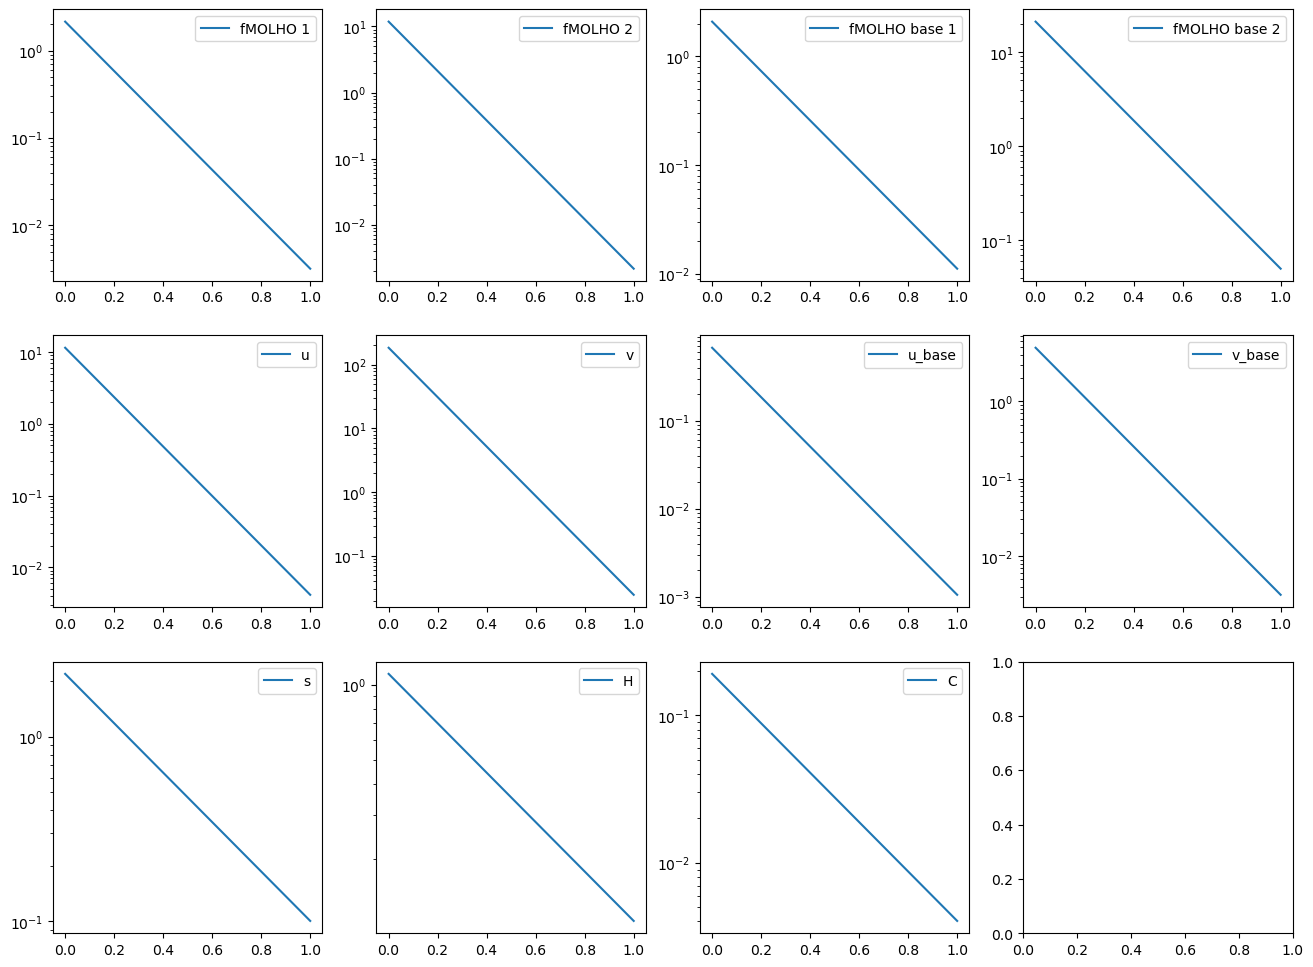

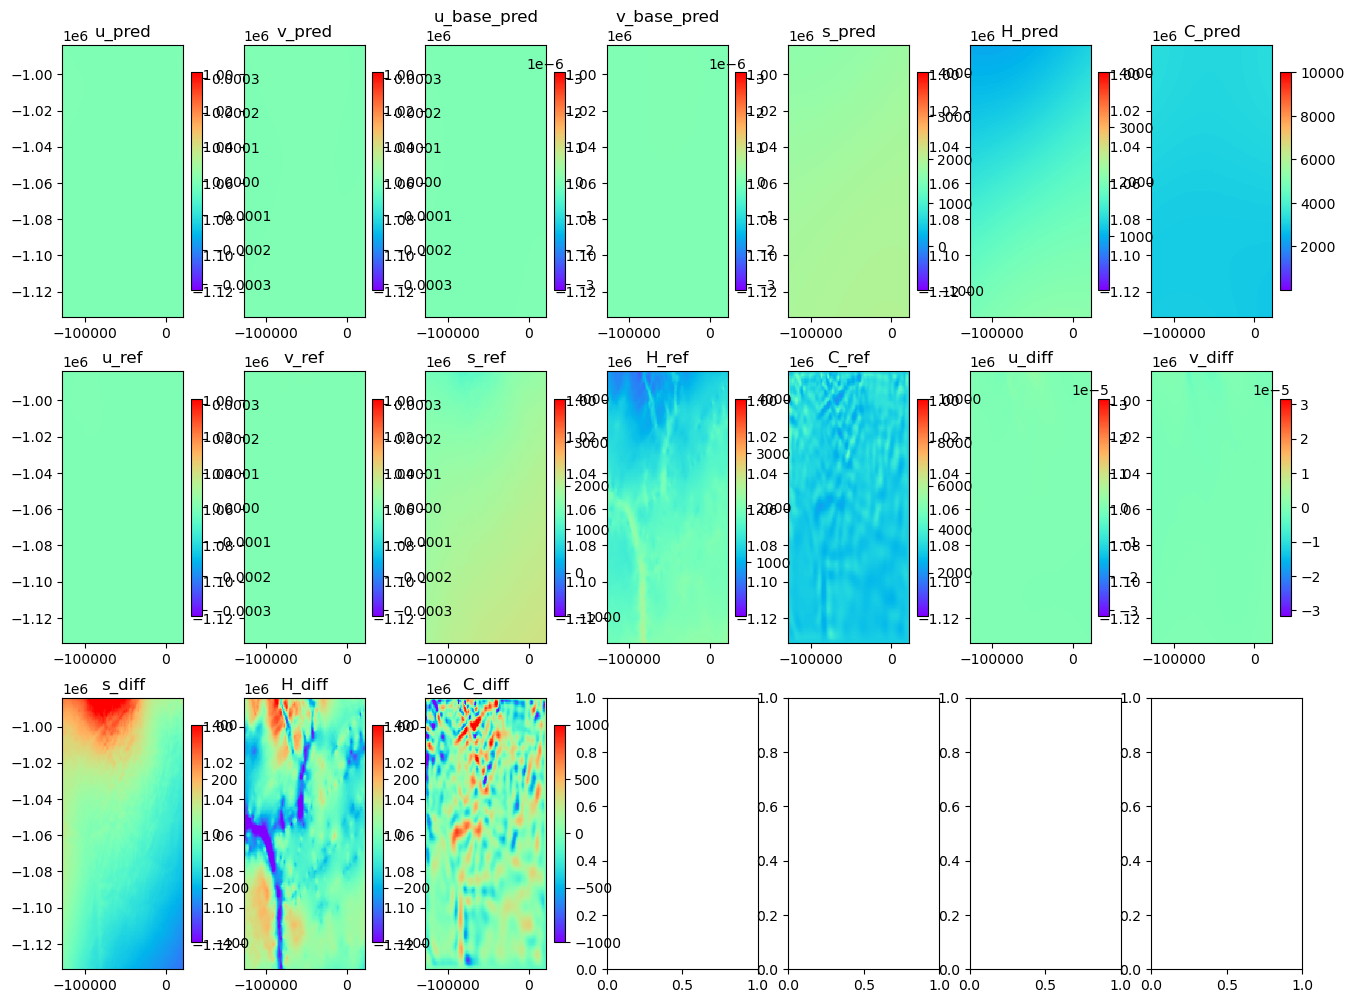

In [8]:
# Now run the PINN model
experiment.compile()

# Train
experiment.train()
# Show results
experiment.plot_predictions(X_ref=experiment.model_data.data["ISSM"].X_dict, sol_ref=experiment.model_data.data["ISSM"].data_dict)

**4. Save results in a .mat file**

In [ ]:
# Save results
import hdf5storage
import scipy

grid_size = 501

    # generate 200x200 mesh on the domain
X, Y = np.meshgrid(np.linspace(experiment.params.nn.input_lb[0], experiment.params.nn.input_ub[0], grid_size),
                   np.linspace(experiment.params.nn.input_lb[1], experiment.params.nn.input_ub[1], grid_size))
X_nn = np.hstack((X.flatten()[:,None], Y.flatten()[:,None]))

# predicted solutions
sol_pred = experiment.model.predict(X_nn)

mat_data = {} # make a dictionary to store the MAT data in
vars2save = ['sol_pred','X_nn']
for i, var_curr in enumerate(vars2save):
    exec(f'mat_data[u"{var_curr}"] = {var_curr}')
 
hdf5storage.savemat(hp["save_path"] + '/' + issm_pinn_path + '_predictions.mat', mat_data, format='7.3', 
                    oned_as='row', store_python_metadata=True)

**Instead of running a new model, simply load a saved model**<br />
Note: Locally installed is the newest version of PINNICLE as of 10 Jan 2025, which successfully opens models saved with the newest version of PINNICLE but not models saved with the version currently installed on the GPU system.

In [16]:
# Import from previous experiment

import pinnicle as pinn
import numpy as np
import deepxde as dde

# Set up some configurations
dde.config.set_default_float('float64')
dde.config.disable_xla_jit()
dde.config.set_random_seed(1234)

## Load settings from previous experiment
model_path = "./PINNs/Ryder_issm2024-Dec-19_3_pinn25-Jan-13_L3"
experiment = pinn.PINN(loadFrom=model_path)

# If you're going to save this in a new place:
# new_folder = './PINNs/Ryder_issm2024-Dec-19_3_pinn25-Jan-09-1La'
# experiment.update_parameters({"save_path": new_folder})

## Load weights from previously trained NN
experiment.load_model(path=model_path)

Disable just-in-time compilation with XLA.


Set the default float type to float64


ERROR:root:ERROR: MATLAB type not supported: qmustatistics, (uint32)
ERROR:root:ERROR: MATLAB type not supported: lovenumbers, (uint32)
ERROR:root:ERROR: MATLAB type not supported: rotational, (uint32)
ERROR:root:ERROR: MATLAB type not supported: solidearthsettings, (uint32)


add input transform with [ -128000. -1134000.] and [  22000. -984000.]
add output transform with [-3.1709792e-04 -3.1709792e-04 -3.1709792e-06 -3.1709792e-06
 -1.0000000e+03  1.0000000e+01  1.0000000e-02] and [3.1709792e-04 3.1709792e-04 3.1709792e-06 3.1709792e-06 4.0000000e+03
 4.0000000e+03 1.0000000e+04]
Compiling model...
'compile' took 0.001121 s



/Users/achartra/Applications/miniforge3/envs/PINNICLE/lib/python3.10/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Compiling model...
'compile' took 0.001098 s



**5. Make my own figures**

In [17]:
# Prepare plotting data - load modules and define functions

import math
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.ticker as ticker
import matplotlib as mpl
from matplotlib.colors import ListedColormap
from scipy.interpolate import griddata
from scipy.spatial import cKDTree as KDTree
import scipy.io as sio
import pandas as pd
from scipy.stats import iqr

def shadecalc_pre(s, u, v, resolution):
    # CALCULATE SURFACE SLOPE AND ALONG-FLOW SURFACE SLOPE AND MAKE FLOW-AWARE HILLSHADE
    print('Use filtered surface speed with elevation azimuth and calculate along-flow surface slope...')

    speed_filt = np.sqrt(np.square(u) + np.square(v))
    
    # surface-velocity and elevation-gradient flow azimuths
    az_speed = np.arctan2(v, u) # rad
    [elev_grad_y, elev_grad_x] = np.gradient(s, resolution)
    az_elev = np.arctan2(-elev_grad_y, -elev_grad_x) # rad
    
    [num_y, num_x]		= s.shape
    
    # extract trigonometric elements
    az_sin_cat, az_cos_cat = np.full((num_y, num_x, 2), np.nan), np.full((num_y, num_x, 2), np.nan)
    az_sin_cat[:, :, 0] = np.sin(az_speed)
    az_cos_cat[:, :, 0] = np.cos(az_speed)
    az_sin_cat[:, :, 1] = np.sin(az_elev)
    az_cos_cat[:, :, 1] = np.cos(az_elev)
    
    # weight filter exponentially using reference speed
    speed_az_decay = 100 # speed above which weight is unity for InSAR surface speeds, m/s (100 in GBTSv1)
    # speed_uncert_rel_decay = 0.25 # (0.1 in GBTSv1, 0.25 here), also fractional cutoff for speeds
    wt_az_elev = np.exp(-speed_filt / speed_az_decay) # + np.exp(-speed_uncert_rel_decay ./ (speed_uncert_filt ./ speed_filt)) % characteristic length of surface speed to unity ratio
    wt_az_elev[wt_az_elev > 1] = 1
    wt_az_speed = 1 - wt_az_elev
    wt_az_elev[np.isnan(az_speed)] = 1 # maximum weight (1) if the other is NaN
    wt_az_speed[np.isnan(az_elev)] = 1
    az_mean = np.arctan2((az_sin_cat[:, :, 0] * wt_az_speed) + (az_sin_cat[:, :, 1] * wt_az_elev), (az_cos_cat[:, :, 0] * wt_az_speed) + (az_cos_cat[:, :, 1] * wt_az_elev)) # mean azimuth, radians
    az_mean_cos = np.cos(az_mean) # rad
    az_mean_sin = np.sin(az_mean) # rad
    
    # Prepare to fix hillshade wrap issue
    az_wrap_cutoff = 150 # cutoff near 0/360 to address wrapping
    tmp1 = np.mod(np.degrees(az_mean), 360) # current projected Cartesian flow direction
    tmp1[(tmp1 >= az_wrap_cutoff) & (tmp1 <= 360 - az_wrap_cutoff)] = np.nan # add 360 deg to azimuths to get them well away from 0 (the wrapping problem)
    tmp2 = np.copy(tmp1) # interpolate cutoff azimuths onto full DEM grid (100 m)
    tmp3 = np.mod(np.degrees(az_mean), 360) # interpolate original azimuths onto full DEM grid
    tmp3[~np.isnan(tmp2)] = np.mod(tmp2[~np.isnan(tmp2)] - 360, 360) # take interpolated cutoff azimuths, remove the 360 deg, then wrap them, and put them where original azimuths were
    
    # use raw speed azimuth along margin where gridding breaks down
    az_speed = np.mod(np.degrees(np.arctan2(v, u)), 360)
    tmp3[np.isnan(tmp3) * ~np.isnan(az_speed)] = az_speed[np.isnan(tmp3) & ~np.isnan(az_speed)]
    az = np.radians(tmp3)
    return az


def shadecalc_alt(dem, resolution, az, el, zf):
    fy, fx = np.gradient(dem, resolution) # simple, unweighted gradient of immediate neighbours
    # Cartesian to polar coordinates for gradient:
    asp = np.arctan2(fy, fx)
    grad = np.hypot(fy, fx)
    # grad = np.radians(np.sqrt(fx**2 + fy**2))
    
    grad = np.arctan(grad * zf) # multiply gradient angle by z-factor
    hs = (np.cos(el) * np.cos(grad)) + (np.sin(el) * np.sin(grad) * np.cos(az - asp)) # ESRI's algorithm
    hs[hs < 0] = 0 # set hillshade values to min of 0
    return hs



In [10]:
if "velbase" in experiment.model_data.data:
    print('exists!')
else:
    print("doesn't exist!")

doesn't exist!


In [18]:
# Prepare plotting data - MOLHO

grid_size = 501
# generate grid_size x grid_size mesh on the domain
X, Y = np.meshgrid(np.linspace(experiment.params.nn.input_lb[0], experiment.params.nn.input_ub[0], grid_size),
                   np.linspace(experiment.params.nn.input_lb[1], experiment.params.nn.input_ub[1], grid_size))
X_nn = np.hstack((X.flatten()[:,None], Y.flatten()[:,None]))

X_ref=experiment.model_data.data["ISSM"].X_dict
X_ref = np.hstack((X_ref['x'].flatten()[:,None],X_ref['y'].flatten()[:,None]))

resolution = X[0,1] - X[0,2]
yts = pinn.physics.Constants().yts

# reference data
sol_ref=experiment.model_data.data["ISSM"].data_dict
if "velbase" in experiment.model_data.data:
    sol_ref.update(experiment.model_data.data["velbase"].data_dict)
else:
    sol_ref.update({"u_base":1.0e-8*np.ones(sol_ref["u"].shape), "v_base":1.0e-8*np.ones(sol_ref["u"].shape)})
    
ref_data = {k:griddata(X_ref, sol_ref[k].flatten(), (X, Y), method='cubic') for k in experiment.params.nn.output_variables if k in sol_ref}

ref_data["u"] = yts*ref_data["u"]
ref_data["v"] = yts*ref_data["v"]
ref_data["u_base"] = yts*ref_data["u_base"]
ref_data["v_base"] = yts*ref_data["v_base"]
ref_data_plot = {"vel": np.sqrt(np.square(ref_data["u"]) + np.square(ref_data["v"])), "vel_base": np.sqrt(np.square(ref_data["u_base"]) + np.square(ref_data["v_base"])),
                 "hs":[], "C":ref_data["C"], "bed_elev":ref_data["s"] - ref_data["H"]}

# Get hillshade for reference surface
ref_az = shadecalc_pre(ref_data["s"], ref_data["u"], ref_data["v"], resolution)
#                                         dem         dx           az                 el             zf
ref_data_plot["hs"] = shadecalc_alt(ref_data["s"], resolution, ref_az + (np.pi/2), np.radians(30), 200) # hillshade lit across flow azimuth

ref_names = ref_data_plot.keys()

# predicted solutions
sol_pred = experiment.model.predict(X_nn)
pred_data = {k:np.reshape(sol_pred[:,i:i+1], X.shape) for i,k in enumerate(experiment.params.nn.output_variables)}
data_names = pred_data.keys()

pred_data["u"] = yts*pred_data["u"]
pred_data["v"] = yts*pred_data["v"]
pred_data["vel"] = np.sqrt(np.square(pred_data["u"]) + np.square(pred_data["v"]))
pred_data["u_base"] = yts*pred_data["u_base"]
pred_data["v_base"] = yts*pred_data["v_base"]
pred_data["vel_base"] = np.sqrt(np.square(pred_data["u_base"]) + np.square(pred_data["v_base"]))
pred_data["bed_elev"] = ref_data["s"] - pred_data["H"]

# Get hillshade for predicted surface
pred_az = shadecalc_pre(pred_data["s"], pred_data["u"], pred_data["v"], resolution)
#                                         dem         dx           az                 el             zf
pred_data["hs"] = shadecalc_alt(pred_data["s"], resolution, pred_az + (np.pi / 2), np.radians(30), 200) # hillshade lit across flow azimuth

# Get percent differences
perc_diff = {}
perc_diff["vel"]= ((pred_data["vel"] - ref_data_plot["vel"])/ref_data_plot["vel"])*100
perc_diff["vel_base"]= ((pred_data["vel_base"] - ref_data_plot["vel_base"])/ref_data_plot["vel_base"])*100
perc_diff["s"]= ((pred_data["s"] - ref_data["s"])/ref_data["s"])*100
perc_diff["C"]= ((pred_data["C"] - ref_data_plot["C"])/ref_data_plot["C"])*100
perc_diff["bed_elev"]= ((pred_data["bed_elev"] - ref_data_plot["bed_elev"])/ref_data_plot["bed_elev"])*100

Use filtered surface speed with elevation azimuth and calculate along-flow surface slope...


Use filtered surface speed with elevation azimuth and calculate along-flow surface slope...


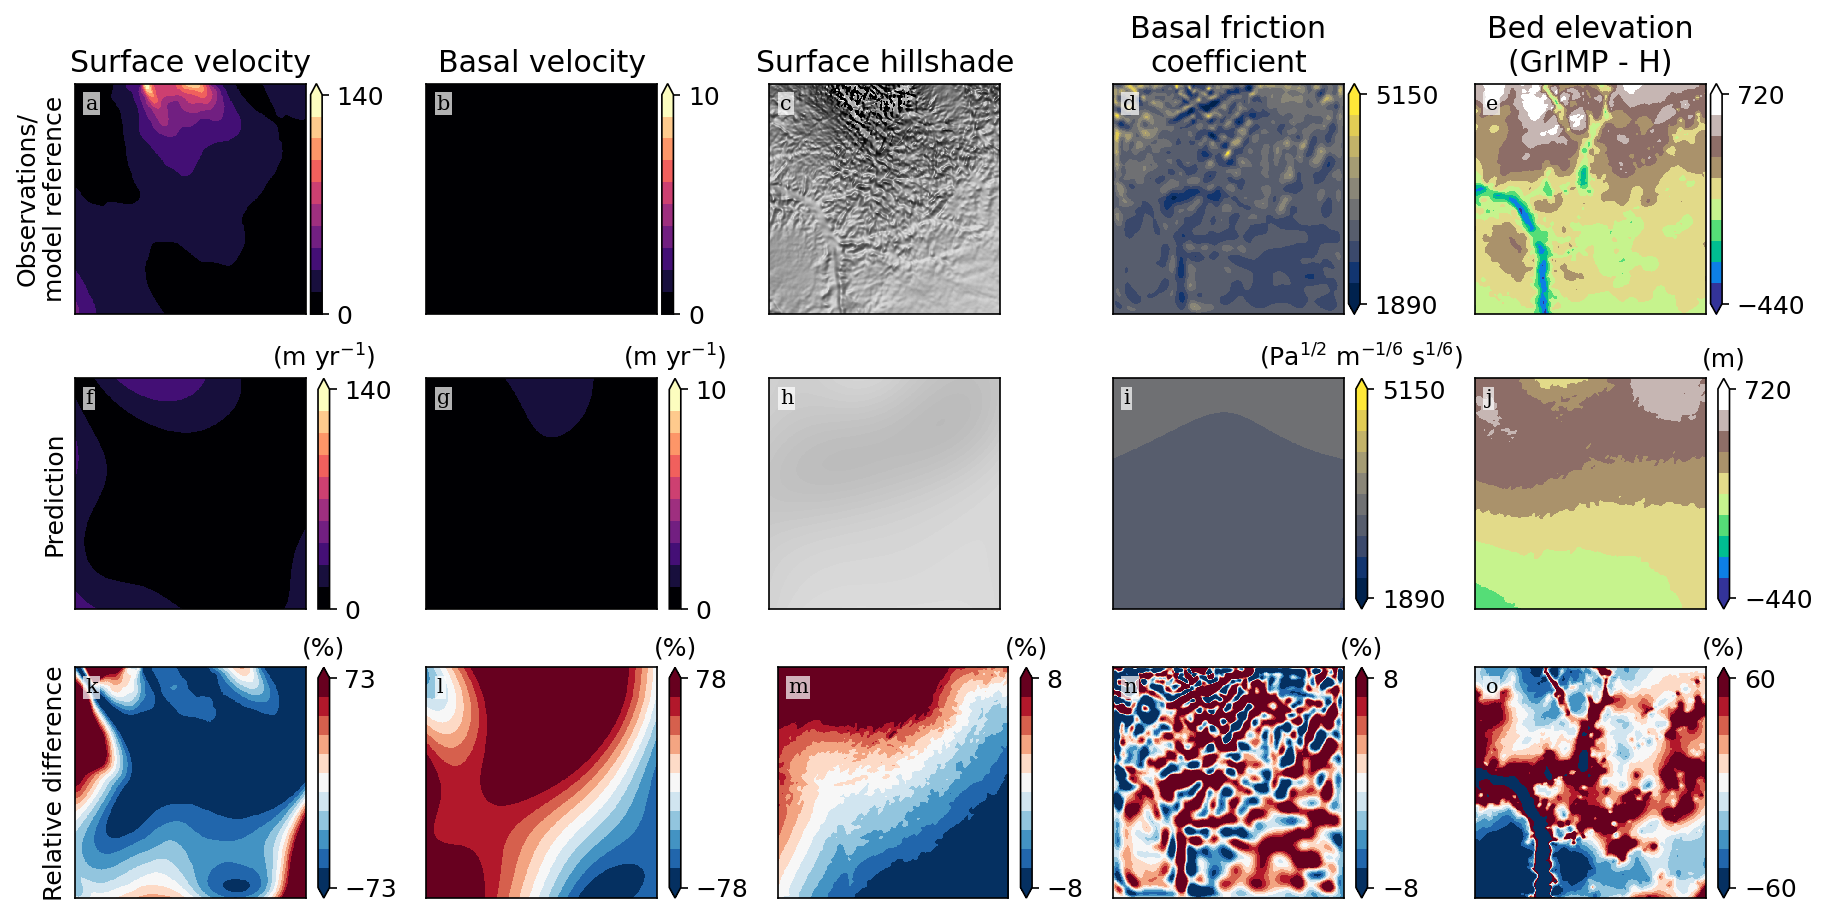

In [19]:
# Get colorbar ranges for plotting data
cranges = {name:[np.round(np.min(ref_data_plot[name]),decimals=-1), np.round(np.max(ref_data_plot[name]),decimals=-1)] for name in ref_names}
# cranges["u_base"] = [-10, 10]
# cranges["v_base"] = [-10, 10]
cranges["vel_base"] = [0, 10]
cranges["hs"] = [0.0, 1.0]

q75_pd = {name:np.quantile(np.abs(perc_diff[name]),0.75) for name in perc_diff.keys()}
cranges_pd = {name:[np.round(-1*q75_pd[name]), np.round(q75_pd[name])] for name in perc_diff.keys()}
if np.max(cranges_pd["vel_base"]) > 100:
    cranges_pd["vel_base"] = [-100, 100]

clabels = {name:[] for name in ref_names}
# clabels["u"] = "m/yr"
# clabels["v"] = "m/yr"
clabels["vel"] = "(m yr$^\mathrm{-1}$)"
# clabels["u_base"] = "m/yr"
# clabels["v_base"] = "m/yr"
clabels["vel_base"] = "(m yr$^\mathrm{-1}$)"
clabels["hs"] = ""
clabels["C"] = "(Pa$^\mathrm{1/2}$ m$^\mathrm{-1/6}$ s$^\mathrm{1/6}$)"
clabels["bed_elev"] = "(m)"

cmaps = {name:[] for name in ref_names}
# cmaps["u"] = plt.get_cmap("magma", 10)
# cmaps["v"] = plt.get_cmap("magma", 10)
cmaps["vel"] = plt.get_cmap("magma",10)
# cmaps["u_base"] = plt.get_cmap("magma",10)
# cmaps["v_base"] = plt.get_cmap("magma",10)
cmaps["vel_base"] = plt.get_cmap("magma",10)
cmaps["hs"] = plt.get_cmap("gray", 100)
cmaps["C"] = plt.get_cmap("cividis", 10)
cmaps["bed_elev"] = plt.get_cmap("terrain", 10)

cols = len(ref_names)

# Make the plots
import string

titles = {"vel":"Surface velocity", "vel_base":"Basal velocity", "hs":"Surface hillshade", "C":"Basal friction\ncoefficient",
          "bed_elev":"Bed elevation\n(GrIMP - H)"}
extends = {"vel":"max", "vel_base":"max", "hs":"neither","C":"both","bed_elev":"both"}


alphabet = list(string.ascii_lowercase)
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.size"] = 12

# for ax, name in zip(axs.ravel(), ref_data.keys()):
fig, axs = plt.subplots(3, cols, figsize=(12,6),dpi=150,layout='constrained')
# fig.subplots_adjust(left=0.1, hspace=0.0, wspace=0.45)
for ax, name in zip(axs[0], ref_data_plot.keys()):
    vr = cranges.setdefault(name, [None, None])
    im = ax.imshow(ref_data_plot[name], interpolation='nearest', cmap=cmaps[name],
                   extent=[X.min(), X.max(), Y.min(), Y.max()],
                   vmin=vr[0], vmax=vr[1],
                   aspect='equal', origin='lower')
    ax.set_title(titles[name])
    ax.tick_params(left = False, right = False , labelleft = False ,
                   labelbottom = False, bottom = False)
    if len(clabels[name]) > 0:
        cbar = plt.colorbar(im, ax=ax, fraction=0.048, location="right", pad=0.02, extend = extends[name], ticks=vr) 
    

for ax, name in zip(axs[1], ref_data_plot.keys()):
    vr = cranges.setdefault(name, [None, None])
    im = ax.imshow(pred_data[name], interpolation='nearest', cmap=cmaps[name],
                   extent=[X.min(), X.max(), Y.min(), Y.max()],
                   vmin=vr[0], vmax=vr[1],
                   origin='lower', aspect='equal')
    # ax.set_title(name+"_pred")
    ax.tick_params(left = False, right = False , labelleft = False , 
                   labelbottom = False, bottom = False)
    if len(clabels[name]) > 0:
        cbar = fig.colorbar(im, ax=ax, fraction=0.048, location="right", extend = extends[name], ticks=vr) 
        cbar.ax.set_title(clabels[name],fontsize='medium')

# fig, axs = plt.subplots(math.floor(n/cols), cols, figsize=(12,9))
for ax, name in zip(axs[2], perc_diff.keys()):
    vr = cranges_pd.setdefault(name, [None, None])
    im = ax.imshow(perc_diff[name], interpolation='nearest', cmap=plt.get_cmap('RdBu_r',11),
                   extent=[X.min(), X.max(), Y.min(), Y.max()],
                   vmin=vr[0], vmax=vr[1],
                   aspect='equal', origin='lower')
    ax.tick_params(left = False, right = False , labelleft = False ,
                   labelbottom = False, bottom = False)
    cbar = fig.colorbar(im, ax=ax, fraction = 0.048, location="right", extend="both",ticks=vr) 
    cbar.ax.set_title("(%)",fontsize='medium') #, y=1.15, rotation=0)

axs[0,0].set_ylabel("Observations/\nmodel reference")
axs[1,0].set_ylabel("Prediction")
axs[2,0].set_ylabel("Relative difference")

for ax, label in zip(axs.ravel(), alphabet):
    ax.annotate(label,
    xy=(0, 1), xycoords='axes fraction',
    xytext=(+0.5, -0.5), textcoords='offset fontsize',
    fontsize='small', verticalalignment='top', fontfamily='serif',
    bbox=dict(facecolor='1.0', edgecolor='none', pad=1.0,alpha=0.7))

if 'hp' in locals():
    plt.savefig(hp["save_path"]+"/2Dsolutions")
else:
    plt.savefig(experiment.params.param_dict["save_path"]+"/2Dsolutions")

Loading history


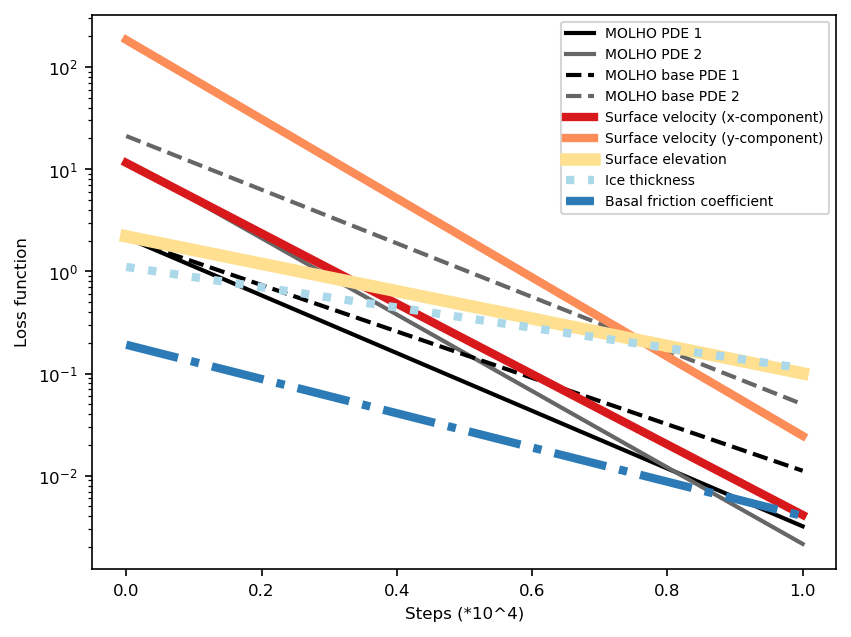

In [20]:
# Plot history on one axis
from pinnicle.utils.history import load_dict_from_json

# Plot Loss History on one axis
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.size"] = 8

if 'hp' in locals():
    print('Using already loaded history')
    history = experiment.history.history
    # loss_keys = [k for k in experiment.history.history.keys() if k != "steps"]
else:
    print('Loading history')
    history = load_dict_from_json(model_path,"history.json")
    # loss_keys = [k for k in experiment.history.keys() if k != "steps"]



fig = plt.figure(dpi = 150) 
plt.plot(history['fMOLHO 1'], "k-", label="MOLHO PDE 1", linewidth=2)
plt.plot(history['fMOLHO 2'], label="MOLHO PDE 2", linestyle="-", c='0.4', linewidth=2)
plt.plot(history['fMOLHO base 1'], "k--", label="MOLHO base PDE 1", linewidth=2)
plt.plot(history['fMOLHO base 2'], label="MOLHO base PDE 2", linestyle="--",linewidth=2, c='0.4')
plt.plot(history['u'], label='Surface velocity (x-component)', linewidth=4, c='#d7191c')
plt.plot(history['v'], label='Surface velocity (y-component)', linewidth=4, c='#fc8d59')
plt.plot(history['s'], label='Surface elevation', linewidth=6, c='#fee090')
plt.plot(history['H'], label='Ice thickness', linewidth=4, c='#abd9e9', linestyle=":")
plt.plot(history['C'], label='Basal friction coefficient', linewidth=4, linestyle="-.", c='#2c7bb6')

plt.legend(loc=1,fontsize='small')
plt.yscale('log')
plt.xlabel('Steps (*10^4)')
plt.ylabel('Loss function')

if 'hp' in locals():
    plt.savefig(hp["save_path"]+"/History_1ax")
else:
    plt.savefig(experiment.params.param_dict["save_path"]+"/History_1ax")

/Users/achartra/Applications/miniforge3/envs/PINNICLEplus/lib/python3.12/site-packages/osgeo/gdal.py:311: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(
ERROR:root:ERROR: MATLAB type not supported: qmustatistics, (uint32)
ERROR:root:ERROR: MATLAB type not supported: lovenumbers, (uint32)
ERROR:root:ERROR: MATLAB type not supported: rotational, (uint32)
ERROR:root:ERROR: MATLAB type not supported: solidearthsettings, (uint32)


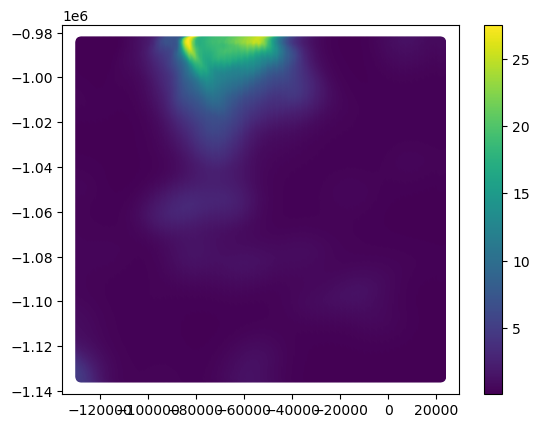

In [1]:
# Estimate basal velocities
# package import
import numpy as np
import h5py
import matplotlib.pyplot as plt
import matplotlib.path as mpath
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import colormaps
import netCDF4 as nc
import mat73
from osgeo import gdal
import scipy as sp
import pandas as pd
import geopandas as gpd
import string
from pyproj import Transformer, Proj
import shapely.geometry as shp_geo
import importlib
import math


Path2dataGS					= '/Users/achartra/Library/CloudStorage/OneDrive-NASA/Greenland-scape/Data/';
# Get beta
beta_tif = gdal.Open(Path2dataGS + 'SIA_Results/SIA_Results_slopeflow/GrIS_SIA_beta_150m.tif')
# Get geotransform parameters (affine transformation coefficients)
geotransform = beta_tif.GetGeoTransform()
# Read raster data (you may need to loop through bands if there are multiple)
beta = beta_tif.GetRasterBand(1)
beta = beta.ReadAsArray()

beta[beta == -9999] = np.nan

x1 = geotransform[0] + np.arange(beta_tif.RasterXSize)*geotransform[1]
y1 = geotransform[3] + np.arange(beta_tif.RasterYSize)*geotransform[5]

# im = plt.imshow(beta, interpolation='nearest',
#                    extent=[x1.min(), x1.max(), y1.min(), y1.max()],
#                    origin='upper', aspect='equal')

# Get mask
Mask_tif					= gdal.Open(Path2dataGS + 'GrIS_BM5_ice_sheet_mask_150m.tif')
Mask = Mask_tif.GetRasterBand(1)
Mask = Mask.ReadAsArray()

# Get velocities
velx_tif = gdal.Open(Path2dataGS + 'AMC_test/GrIS_Meas_250m_AvgSurfVel_speed_x_filt_150m.tif')
vely_tif = gdal.Open(Path2dataGS + 'AMC_test/GrIS_Meas_250m_AvgSurfVel_speed_y_filt_150m.tif')
vel_tif = gdal.Open(Path2dataGS + 'AMC_test/GrIS_Meas_250m_AvgSurfVel_speed_filt_150m.tif')
velx = velx_tif.GetRasterBand(1)
velx = velx.ReadAsArray()
vely = vely_tif.GetRasterBand(1)
vely = vely.ReadAsArray()
vel = vel_tif.GetRasterBand(1)
vel = vel.ReadAsArray()
velx[Mask == False] = np.nan
vely[Mask == False] = np.nan
vel[Mask == False] = np.nan

# Get PINNICLE data for mesh
Region						= 'Ryder';
PINNICLE_path				= '/Users/achartra/Library/CloudStorage/OneDrive-NASA/Greenland-scape/GreenlandScape_PINNICLE/'
ISSM_run					= 'Ryder_issm2024-Dec-19_3'
ISSM_file					= PINNICLE_path + 'Models/' + ISSM_run + '.mat'
# load ISSM model from a `.mat` file
# Reading matlab data
data = mat73.loadmat(ISSM_file)
# get the model
md = data['md']

x = md['mesh']['x']
y = md['mesh']['y']

x_min, x_max = x.min(), x.max()
y_min, y_max = y.min(), y.max()
nx = (x1 >= x_min) & (x1 <= x_max)
ny = (y1 >= y_min) & (y1 <= y_max)

ss_beta = beta[ny, :][:, nx]
ss_beta = sp.ndimage.gaussian_filter(ss_beta, sigma=50)

ss_x	= x1[nx]
ss_y	= y1[ny]

# Estimate basal velocity
vel_base					= vel[ny, :][:, nx] * ss_beta;
u_base						= velx[ny, :][:, nx] * ss_beta;
v_base						= vely[ny, :][:, nx] * ss_beta;


# Interpolate to mesh
u_base_interp = sp.interpolate.RegularGridInterpolator((ss_y, ss_x), u_base, method='linear',bounds_error=False, fill_value=None)
md_u_base = u_base_interp((y, x))

v_base_interp = sp.interpolate.RegularGridInterpolator((ss_y, ss_x), v_base, method='linear',bounds_error=False, fill_value=None)
md_v_base = v_base_interp((y, x))

beta_interp = sp.interpolate.RegularGridInterpolator((ss_y, ss_x), ss_beta, method='linear', bounds_error=False, fill_value=None)
md_beta = beta_interp((y, x))


yts				= 60*60*24*365;

# md_u_base = md_u_base/yts;
# md_v_base = md_v_base/yts;

plt.scatter(x, y, c= np.sqrt((md_u_base**2) + (md_v_base**2)))
plt.colorbar()

# save(strcat(PINNICLE_path,Region,'_vel_base_ms.mat'),'x','y','md_u_base','md_v_base','-v7.3')

In [16]:
# print(len(experiment.training_data))
# print(dir(experiment.training_data[4]))
# print(vars(experiment.training_data[4]))
# print(type(experiment.training_data[3]))
# print(getattr(experiment.training_data[4],'values'))
# print(dir(experiment.training_data[4].collocation_points))
print((experiment.dde_data.bcs[0].values))
# print(type(experiment.domain.vertices))
# print(experiment.dde_data.test_x.shape)


tf.Tensor(
[[-2.36693325e-07]
 [-6.16092102e-07]
 [-2.01784517e-07]
 ...
 [-2.12616102e-07]
 [-2.24413725e-07]
 [-6.60012407e-07]], shape=(8000, 1), dtype=float64)


# Accessing PINNICLE parts


print(dir(experiment))<br>
['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_update_nn_parameters', '_update_ub_lb_in_nn', 'check_path', 'compile', 'dde_data', 'domain', 'load_model', 'load_setting', 'loss_names', 'model', 'model_data', 'nn', 'params', 'physics', 'plot_history', 'plot_predictions', 'save_history', 'save_model', 'save_setting', 'setup', 'train', 'training_data', 'update_callbacks', 'update_parameters', 'update_training_data']<br>
<br>
Class of each thing listed with dir(experiment)<br>
print(type(experiment.xxxx))<br>
| subclass | class | value |
| ------------- | ------------- | ------------- |
| check_path | method | | 
| compile | method | | 
| load_model | method | | 
| load_setting | method | | 
| plot_history | method | | 
| plot_predictions | method | | 
| save_history | method | | 
| save_model | method | | 
| save_setting | method | | 
| setup | method | | 
| train | method | | 
| update_callbacks | method | | 
| update_parameters | method | | 
| update_training_data | method | | 
| dde_data | deepxde.data.pde.PDE | | 
| domain | pinnicle.domain.domain.Domain | | 
| loss_names | list | ['fSSA1', 'fSSA2', 'u', 'v', 's', 'H', 'C', 'vel log'] |
| model | deepxde.model.Model | | 
| model_data | pinnicle.modeldata.data.Data | | 
| nn | pinnicle.nn.nn.FNN | | 
| params | pinnicle.parameter.Parameters | | 
| physics | pinnicle.physics.physics.Physics | | 
| training_data | list |  [<deepxde.icbc.boundary_conditions.PointSetBC object at 0x344632170>, <deepxde.icbc.boundary_conditions.PointSetBC object at 0x344630df0>, <deepxde.icbc.boundary_conditions.PointSetBC object at 0x3446bda80>, <deepxde.icbc.boundary_conditions.PointSetBC object at 0x3446bda20>, <deepxde.icbc.boundary_conditions.PointSetBC object at 0x3446bdae0>, <deepxde.icbc.boundary_conditions.PointSetOperatorBC object at 0x344631d80>] | 
<br>
<br>
<br>
<br>
print(experiment.params) # Different from vars(experiment.params) or dir(experiment.params) because of custom _getattr_ function
Parameters: 
	TrainingParameter: 
		epochs:	10000
		optimizer:	adam
		loss_functions:	['MSE', 'MSE', 'MSE', 'MSE', 'MSE', 'MSE', 'MSE', <function surface_log_vel_misfit_tf at 0x3270f0ca0>]
		additional_loss:	{'vel': <pinnicle.parameter.LossFunctionParameter object at 0x3446bd510>}
		learning_rate:	0.0001
		loss_weights:	[1e-10, 1e-10, 9945192.96, 9945192.96, 1e-06, 1e-06, 1e-08, 1e-05]
		has_callbacks:	False
		min_delta:	None
		patience:	None
		period:	None
		checkpoint:	False
		save_path:	./PINNs/Ryder_test_I22-Nov-2024_15-55-05_P25-Nov-24_13-21-43
		is_save:	False
		is_plot:	False
	DomainParameter: 
		shapefile:	./Ryder_32_09.exp
		num_collocation_points:	5000
		time_dependent:	False
		start_time:	0
		end_time:	0
	DataParameter: 
		ISSM:
			data_path:	./Models/Ryder_test_I22-Nov-2024_15-55-05.mat
			data_size:	{'u': 8000, 'v': 8000, 's': 8000, 'H': 8000, 'C': 8000, 'vel': 8000}
			name_map:	{'u': 'u', 'v': 'v', 's': 's', 'H': 'H', 'C': 'C', 'vel': 'vel'}
			X_map:	{'x': 'x', 'y': 'y', 't': 't'}
			source:	ISSM
			default_time:	None

	NNParameter: 
		input_variables:	['x', 'y']
		output_variables:	['u', 'v', 's', 'H', 'C']
		num_neurons:	20
		num_layers:	6
		activation:	tanh
		initializer:	Glorot uniform
		fft:	False
		num_fourier_feature:	10
		sigma:	1.0
		B:	None
		is_parallel:	False
		input_lb:	[ -128000. -1134000.]
		input_ub:	[  22000. -984000.]
		output_lb:	[-3.1709792e-04 -3.1709792e-04 -1.0000000e+03  1.0000000e+01
  1.0000000e-02]
		output_ub:	[3.1709792e-04 3.1709792e-04 3.6000000e+03 3.5000000e+03 1.0000000e+04]
		input_size:	2
		output_size:	5
	PhysicsParameter: 
		SSA:
			rhoi:	917.0
			rhow:	1023.0
			g:	9.81
			yts:	31536000.0
			variable_lb:	{'u': -0.00031709791983764585, 'v': -0.00031709791983764585, 's': -1000.0, 'H': 10.0, 'C': 0.01, 'a': -1.5854895991882294e-07, 'B': 70000000.0, 'u_base': -0.00031709791983764585, 'v_base': -0.00031709791983764585}
			variable_ub:	{'u': 0.00031709791983764585, 'v': 0.00031709791983764585, 's': 3600.0, 'H': 3500.0, 'C': 10000.0, 'a': 1.5854895991882294e-07, 'B': 700000000.0, 'u_base': 0.00031709791983764585, 'v_base': 0.00031709791983764585}
			input:	['x', 'y']
			output:	['u', 'v', 's', 'H', 'C']
			output_lb:	[-0.00031709791983764585, -0.00031709791983764585, -1000.0, 10.0, 0.01]
			output_ub:	[0.00031709791983764585, 0.00031709791983764585, 3600.0, 3500.0, 10000.0]
			data_weights:	[9945192.96, 9945192.96, 1e-06, 1e-06, 1e-08]
			residuals:	['fSSA1', 'fSSA2']
			pde_weights:	[1e-10, 1e-10]
			scalar_variables:	{'n': 3.0, 'B': 52783360.0}





### experiment.dde_data<br>
print(dir(experiment.dde_data))<br>
print(type(experiment.dde_data.xxxx))<br>
| subclass | class | value |
| ------------- | ------------- | ------------- |
| add_anchors |    method | | 
| bc_points |      method | | 
| losses |         method | | 
| losses_test |    method | | 
| losses_train |   method | | 
| pde |            method | | 
| replace_with_anchors | method | | 
| resample_train_points | method | | 
| test |           method | | 
| test_points |    method | | 
| train_next_batch | method | | 
| train_points |   method | | 
| anchors  |       NoneType | | 
| auxiliary_var_fn | NoneType | 
| bcs  | list | [<deepxde.icbc.boundary_conditions.PointSetBC object at 0x344632170>, <deepxde.icbc.boundary_conditions.PointSetBC object at 0x344630df0>, <deepxde.icbc.boundary_conditions.PointSetBC object at 0x3446bda80>, <deepxde.icbc.boundary_conditions.PointSetBC object at 0x3446bda20>, <deepxde.icbc.boundary_conditions.PointSetBC object at 0x3446bdae0>, <deepxde.icbc.boundary_conditions.PointSetOperatorBC object at 0x344631d80>] | 
| exclusions |     NoneType | | 
| geom |           deepxde.geometry.geometry_2d.Polygon | | 
| num_bcs |        list |                                  [8000, 8000, 8000, 8000, 8000, 8000] | 
| num_boundary |   int |                                   0 | 
| num_domain |     int |                                   5000 | 
| num_test |       NoneType | | 
| soln  |          NoneType | | 
| test_aux_vars |  NoneType | | 
| test_x |         numpy.ndarray | shape (53000, 2) | 
| test_y |         NoneType | | 
| train_aux_vars | NoneType | | 
| train_distribution | str |                                Hammersley | 
| train_x |        numpy.ndarray | shape (53000, 2) | 
| train_x_all |    numpy.ndarray | shape (5000, 2) | 
| train_x_bc |     numpy.ndarray | shape (48000, 2) | 
| train_y  |       NoneType | | 

#### experiment.dde_data.geom
| subclass | class | value |
| ------------- | ------------- | ------------- |
| background_points | method | |
| boundary_constraint_factor | method | |
| boundary_normal | method | |
| difference | method | |
| distance2boundary | method | |
| inside | method | | 
| intersection | method | |
| mindist2boundary | method | |
| on_boundary | method | |
| periodic_point | method | |
| random_boundary_points | method | |
| random_points | method | |
| uniform_boundary_points | method | |
| uniform_points | method | |
| union | method | |
| area | numpy.float64 | 22500000000.0 |
| bbox | numpy.ndarray | [[ -128000. -1134000.]
 [   22000.  -984000.]] |
| diagonals | numpy.ndarray | shape (5, 5) |
| diam | numpy.float64 | 212132.03435596425 |
| dim | int | 2 |
| idstr | str | Polygon |
| normal | numpy.ndarray | shape (5, 2) |
| nvertices | int | 5 |
| perimeter | numpy.float64 | 600000.0 |
| segments | numpy.ndarray | shape (5, 2) |
| vertices | numpy.ndarray | shape (5, 2) |

### experiment.domain
print(dir(experiment.domain))<br>
print(type(experiment.domain.xxxx))<br>
| subclass | class | value |
| ------------- | ------------- | ------------- |
| get_polygon_vertices | method | | 
| inside |         method | | 
| geometry |       deepxde.geometry.geometry_2d.Polygon | | 
| parameters |     pinnicle.parameter.DomainParameter | | 
| vertices |       list |                                  [[-128000.0, -1134000.0], [0.0, -1134000.0], [22000.0, -1134000.0], [22000.0, -984000.0], [-128000.0, -984000.0]] | 

#### experiment.domain.geometry
| subclass | class | value |
| ------------- | ------------- | ------------- |
| background_points | method | |
| boundary_constraint_factor | method | |
| boundary_normal | method | |
| difference | method | |
| distance2boundary | method | |
| inside | method | |
| intersection | method | |
| mindist2boundary | method | | 
| on_boundary | method | |
| periodic_point | method | |
| random_boundary_points | method | |
| random_points | method | |
| uniform_boundary_points | method | |
| union | method | |
| area | numpy.float64 | 22500000000.0 |
| bbox | numpy.ndarray | shape (2, 2) |
| diagonals | numpy.ndarray | shape (5, 5) | 
| diam | numpy.float64 | 212132.03435596425 |
| dim | int | 2 |
| idistr | str | Polygon |
| normal | numpy.ndarray | shape (5, 2) |
| nvertices | int | 5 |
| perimeter | numpy.float64 | 600000.0 |
| segments | numpy.ndarray | shape (5, 2) |
| vertices | numpy.ndarray | shape (5, 2) |

#### experiment.domain.parameters
| subclass | class | value |
| ------------- | ------------- | ------------- |
| check_consistency | method | |
| end_time | int | 0 |
| has_keys | method | | 
| num_collocation_points | int | 5000 |
| param_dict | dict | {'data': {'ISSM': {'data_path': './Models/Ryder_test_I22-Nov-2024_15-55-05.mat', 'data_size': {'u': 8000, 'v': 8000, 's': 8000, 'H': 8000, 'C': 8000, 'vel': 8000}}}, 'epochs': 10000, 'learning_rate': 0.0001, 'loss_function': 'MSE', 'save_path': './PINNs/Ryder_test_I22-Nov-2024_15-55-05_P25-Nov-24_13-21-43', 'is_save': False, 'is_plot': False, 'activation': 'tanh', 'initializer': 'Glorot uniform', 'num_neurons': 20, 'num_layers': 6, 'input': ['y', 'x'], 'shapefile': './Ryder_32_09.exp', 'num_collocation_points': 5000, 'equations': {'SSA': {'scalar_variables': {'B': 52783360.0}}}, 'additional_loss': {'vel': {'name': 'vel log', 'function': 'VEL_LOG', 'weight': 1e-05}}}| 
| set_default | method | |
| set_parameters | method | |
| shapefile | str | ./Ryder_32_09.exp |
| start_time | int | 0 |
| time_dependent | bool | False |
| update | method | |

### experiment.model<br>
print(dir(experiment.model))<br>
print(type(experiment.model.xxxx))<br>
|subclass |class |value |
| ------------- | ------------- | ------------- |
| compile |           method | | 
| predict |           method | | 
| print_model |       method | | 
| restore |           method | | 
| save  |             method | | 
| state_dict |        method | | 
| train |             method | | 
| batch_size |        NoneType | | 
| callbacks |         NoneType | | 
| data |              deepxde.data.pde.PD | | 
| external_trainable_variables | list | [] | 
| loss_weights |      NoneType | | 
| loss_history |      deepxde.model.LossHistory | | 
| metrics |           NoneType | | 
| net |               deepxde.nn.tensorflow.fnn.FNN | | 
| opt |               NoneType | | 
| opt_name |          NoneType | | 
| outputs  |          NoneType | | 
| outputs_losses_test | Nonetype | | 
| outputs_losses_train | NoneType | | 
| stop_training |     'bool' | False | 
| train_state |       deepxde.model.TrainState | | 
| train_step |        NoneType | | 

<br>
<br>

#### experiment.model.data
| subclass | class | value |
| ------------- | ------------- | ------------- |
| add_anchors | method | |
| bc_points | method | |
| losses | method | |
| losses_test | method | |
| losses_train | method | |
| pde | method | |
| replace_with_anchors | method | |
| resample_train_points | method | |
| test | method | |
| test_points | method | |
| train_next_batch | method | |
| train_points | method | |
| anchors | NoneType | |
| auxiliary_var_fn | NoneType | |
| bcs | list | [<deepxde.icbc.boundary_conditions.PointSetBC object at 0x344632170>, <deepxde.icbc.boundary_conditions.PointSetBC object at 0x344630df0>, <deepxde.icbc.boundary_conditions.PointSetBC object at 0x3446bda80>, <deepxde.icbc.boundary_conditions.PointSetBC object at 0x3446bda20>, <deepxde.icbc.boundary_conditions.PointSetBC object at 0x3446bdae0>, <deepxde.icbc.boundary_conditions.PointSetOperatorBC object at 0x344631d80>] |
| exclusions | NoneType | | 
| geom | deepxde.geometry.geometry_2d.Polygon | | 
| num_bcs | list | [8000, 8000, 8000, 8000, 8000, 8000] |
| num_boundary | int | 0 |
| num_domain | int | 5000 |
| num_test | NoneType | |
| soln | NoneType | |
| test_aux_vars | NoneType | |
| test_x | numpy.ndarray | shape (53000, 2) |
| test_y | NoneType | |
| train_aux_vars | NoneType | |
| train_distribution | str | Hammersley |
| train_x | numpy.ndarray | shape (53000, 2) |
| train_x_all | numpy.ndarray | shape (5000, 2) |
| train_x_bc | numpy.ndarray | shape (48000, 2) |
| train_y | NoneType | |

<br>
<br>


#### experiment.model.losshistory
| subclass | class | value |
| ------------- | ------------- | ------------- |
| append | method | |
| loss_test | list | [] |
| loss_train | list | [] |
| metrics_test | list | [] |
| steps | list | [] |

<br>
<br>

#### experiment.model.net
| subclass | class | value |
| ------------- | ------------- | ------------- |
| add_loss | method | |
| add_metric | method | |
| add_update | method | |
| add_variable | method | |
| add_weight | method | |
| apply_feature_transform | method | |
| apply_output_transform | method | |
| build | method | |
| call | method | | 
| compile | method | |
| compute_loss | method | |
| compute_mask | method | |
| compute_metrics | method | |
| compute_output_shape | method | |
| compute_output_signature | method | |
| count_params | method | |
| evaluate | method | |
| evaluate_generator | method | |
| finalize_state | method | |
| fit | method | |
| fit_generator | method | |
| from_config | method | |
| get_config | method | |
| get_input_at | method | |
| get_input_mask_at | method | |
| get_input_shape_at | method | |
| get_layer | method | |
| get_metrics_result | method | | 
| get_output_at | method | | 
| get_output_mask_at | method | | 
| get_output_shape_at | method | | 
| get_weight_paths | method | | 
| get_weights | method | | 
| load_weights | method | |
| make_predict_function | method | |
| make_test_function | method | |
| make_train_function | method | |
| name_scope | method | |
| num_trainable_parameters | method | |
| predict | method | |
| predict_generator | method | |
| predict_on_batch | method | |
| predict_step | method | |
| reset_metrics | method |  |
| reset_states | method | |
| save | method | |
| save_spec | method | |
| save_weights | method | |
| set_weights | method | |
| summary | method | |
| test_on_batch | method | |
| test_step | method | |
| to_json | method | |
| to_yaml | method | |
| train_on_batch | method | |
| train_step | method | |
| with_name_scope | method |
| activity_regularizer | NoneType | |
| auxiliary_vars | NoneType | |
| built | bool | True |
| compiled_loss | NoneType | |
| compiled_metrics | NoneType | |
| compute_dtype | str | float64 |
| denses | tensorflow.python.trackable.data_structures.ListWrapper | |
| distribute_reduction_method | str | method |
| distribute_strategy | tensorflow.python.distribute.distribute_lib._DefaultDistributionStrategy | |
| dropout_rate | int | 0 |
| dtype | str | float64 |
| dtype_policy | keras.mixed_precision.policy.Policy | |
| dynamic | bool | False |
| history | NoneType | |
| inbound_nodes | list | [] |
| input | Error | |
| input_mask | Error | |
| input_names | NoneType | |
| input_shape | Error | |
| input_spec | NoneType | |
| inputs | NoneType | |
| layers | list | [<keras.layers.core.dense.Dense object at 0x3446bdea0>, <keras.layers.core.dense.Dense object at 0x3446bded0>, <keras.layers.core.dense.Dense object at 0x3446be110>, <keras.layers.core.dense.Dense object at 0x3446be860>, <keras.layers.core.dense.Dense object at 0x3446beb00>, <keras.layers.core.dense.Dense object at 0x3446bf040>, <keras.layers.core.dense.Dense object at 0x3446bf0d0>] |
| losses | list | [] |
| metrics | list | [] |
| metrics_names | list | [] |
| name | str | fnn_1 |
| non_trainable_variables | list | [] |
| non_trainable_weights | list | [] |
| optimizer | NoneType | |
| outbound_nodes | list | [] |
| output | Error | |
| output_mask | Error | |
| output_names | NoneType | |
| output_shape | Error | |
| outputs | NoneType | |
| predict_function | NoneType | |
| regularizer | NoneType | |
| run_eagerly | bool | False |
| state_updates | list | [] |
| stateful | bool | False |
| stop_training | bool | False |
| submodules | tuple | (<keras.layers.core.dense.Dense object at 0x3446bdea0>, <keras.layers.core.dense.Dense object at 0x3446bded0>, <keras.layers.core.dense.Dense object at 0x3446be110>, <keras.layers.core.dense.Dense object at 0x3446be860>, <keras.layers.core.dense.Dense object at 0x3446beb00>, <keras.layers.core.dense.Dense object at 0x3446bf040>, <keras.layers.core.dense.Dense object at 0x3446bf0d0>) |
| supports_masking | bool | False |
| test_function | NoneType | |
| train_function | NoneType | |
| train_tf_function | NoneType | |
| trainable | bool | True |
| trainable_variables | list | length 14 |
| trainable_weights | list | length 14 |
| updates | list | [] |
| variable_dtype | str | float64 |
| variables | list | length 14 |
| weights | list | length 14 |

<br>
<br>

#### experiment.model.train_state
| subclass | class | value |
| ------------- | ------------- | ------------- |
| disregard_best | method | |
| set_data_test | method | |
| set_data_train | method | |
| update_best | method | |
| best_loss_test | numpy.float64 | 0.06511119054858318 |
| best_loss_train | numpy.float64 | 0.06511119054858318 |
| best_metrics | list | [] |
| best_y | numpy.ndarray | shape (53000, 5) |
| best_ystd | NoneType | |
| epoch | int | 10000 |
| loss_test | numpy.ndarray | [1.05431257e-02 7.60757194e-03 4.48367962e-06 5.10836040e-06 1.37268932e-02 2.31275009e-02 5.54470114e-03 4.55180559e-03] |
| loss_train | numpy.ndarray | [1.05431257e-02 7.60757194e-03 4.48367962e-06 5.10836040e-06 1.37268932e-02 2.31275009e-02 5.54470114e-03 4.55180559e-03] | 
| metrics_test | list | [] |
| step | int | 10000 |
| test_aux_vars | NoneType | | 
| train_aux_vars | NoneType | |
| y_pred_test | numpy.ndarray | shape (53000, 5) |
| y_pred_train | numpy.ndarray | shape (53000, 5) |
| y_std_test | NoneType | |
| y_test | NoneType | |
| y_train | NoneType | | 

### experiment.model_data
print(dir(experiment.model_data))<br>
print(type(experiment.model_data.xxxx))<br>
| subclass | class | value |
| ------------- | ------------- | ------------- |
| get_ice_coordinates | method |   |
| load_data |       method |    |
| prepare_training_data | method | |
| data | dict | {"ISSM": <pinnicle.modeldata.issm_data.ISSMmdData object at 0x3446321a0>} |
| g | float | 9.81 |
| parameters | pinnicle.parameter.DataParameter | |
| rhoi | float | 917.0 | 
| rhow | float | 1023.0 | 
| sol | dict | {'u': array, 'v': array, 's': array, 'H': array, 'vel': array, 'C': array} | 
| variable_lb | dict | {'u': -0.00031709791983764585, 'v': -0.00031709791983764585, 's': -1000.0, 'H': 10.0, 'C': 0.01, 'a': -1.5854895991882294e-07, 'B': 70000000.0, 'u_base': -0.00031709791983764585, 'v_base': -0.00031709791983764585} | 
| variable_ub | dict | {'u': 0.00031709791983764585, 'v': 0.00031709791983764585, 's': 3600.0, 'H': 3500.0, 'C': 10000.0, 'a': 1.5854895991882294e-07, 'B': 700000000.0, 'u_base': 0.00031709791983764585, 'v_base': 0.00031709791983764585} | 
| yts | float | 31536000.0 | 

In [8]:
print(dir(experiment.model_data.data))
# print(type(experiment.model.train_state.y_train))
# print(experiment.model.train_state.y_pred_train.shape)

['__class__', '__class_getitem__', '__contains__', '__delattr__', '__delitem__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__ior__', '__iter__', '__le__', '__len__', '__lt__', '__ne__', '__new__', '__or__', '__reduce__', '__reduce_ex__', '__repr__', '__reversed__', '__ror__', '__setattr__', '__setitem__', '__sizeof__', '__str__', '__subclasshook__', 'clear', 'copy', 'fromkeys', 'get', 'items', 'keys', 'pop', 'popitem', 'setdefault', 'update', 'values']


### experiment.nn
print(dir(experiment.nn))
print(type(experiment.nn.xxxx))
| subclass | class | value |
| ------------- | ------------- | ------------- |
| createFNN |             method | | 
| createPFNN |            method | | 
| net |                   deepxde.nn.tensorflow.fnn.FNN | | 
| parameters |            pinnicle.parameter.NNParameter | | 

### experiment.params
print(dir(experiment.params))<br>
print(type(experiment.params.xxxx))<br>
| subclass | class | value |
| ------------- | ------------- | ------------- |
| check_consistency |        method | | 
| has_keys |                 method | | 
| set_default |              method | | 
| set_parameters |           method | | 
| update |                   method | | 
| data |                     pinnicle.parameter.DataParameter | | 
| domain |                   pinnicle.parameter.DomainParameter | | 
| nn |                       pinnicle.parameter.NNParameter | | 
| param_dict |               dict |                           {'data': {'ISSM': {'data_path': <str>, 'data_size': {'u': 8000, 'v': 8000, 's': 8000, 'H': 8000, 'C': 8000, 'vel': 8000}}}, 'epochs': 10000, 'learning_rate': 0.0001, 'loss_function': 'MSE', 'save_path': <str>, 'is_save': False, 'is_plot': False, 'activation': 'tanh', 'initializer': 'Glorot uniform', 'num_neurons': 20, 'num_layers': 6, 'input': ['y', 'x'], 'shapefile': './Ryder_32_09.exp', 'num_collocation_points': 5000, 'equations': {'SSA': {'scalar_variables': {'B': 52783360.0}}}, 'additional_loss': {'vel': {'name': 'vel log', 'function': 'VEL_LOG', 'weight': 1e-05}}} | 
| physics |                  pinnicle.parameter.PhysicsParameter | | 
| training |                 pinnicle.parameter.TrainingParameter | | 

### experiment.physics
print(dir(experiment.physics))<br>
print(type(experiment.physics.xxxx))<br>
| subclass | class | value |
| ------------- | ------------- | ------------- |
| operator |              method | | 
| pdes |                  method | | 
| surf_x |                method | | 
| surf_y |                method | | 
| user_defined_gradient | method | | 
| vel_mag |               method | | 
| data_weights |          list |                   [9945192.96, 9945192.96, 1e-06, 1e-06, 1e-08] | 
| equations |             list |                   [<pinnicle.physics.stressbalance.SSA object at 0x344631d20>] | 
| input_var |             list |                   ['x', 'y'] | 
| output_lb |             list |                   [-0.00031709791983764585, -0.00031709791983764585, -1000.0, 10.0, 0.01] | 
| output_ub |             list |                   [0.00031709791983764585, 0.00031709791983764585, 3600.0, 3500.0, 10000.0] | 
| output_var |            list |                   ['u', 'v', 's', 'H', 'C'] | 
| parameters |            pinnicle.parameter.PhysicsParameter | | 
| pde_weights |           list |                   [1e-10, 1e-10] | | 
| residuals  |            list |                   ['fSSA1', 'fSSA2'] | 